In [1]:
include("meshgenerator.jl")
using LaTeXStrings


In [2]:
u_exact(x, k) = exp(-im * k * x)
cdot(x, y) = real.(dot(conj(x)', y))
H(u, B) = cdot(u, B * u)

H (generic function with 1 method)

In [3]:
function test_case()
    p = [0 0; 1 0; 0 1; 1 1]
    t = [1 2 3; 2 4 3]
    ein = [1 3]
    eout = [2 4]
    K, M, Bin, Bout, bin = femhelmholtz(p, t, ein, eout)
    display(K)
    display(M)
    display(Bin)
    display(Bout)
    display(bin)
end


test_case (generic function with 1 method)

0.999920347556088


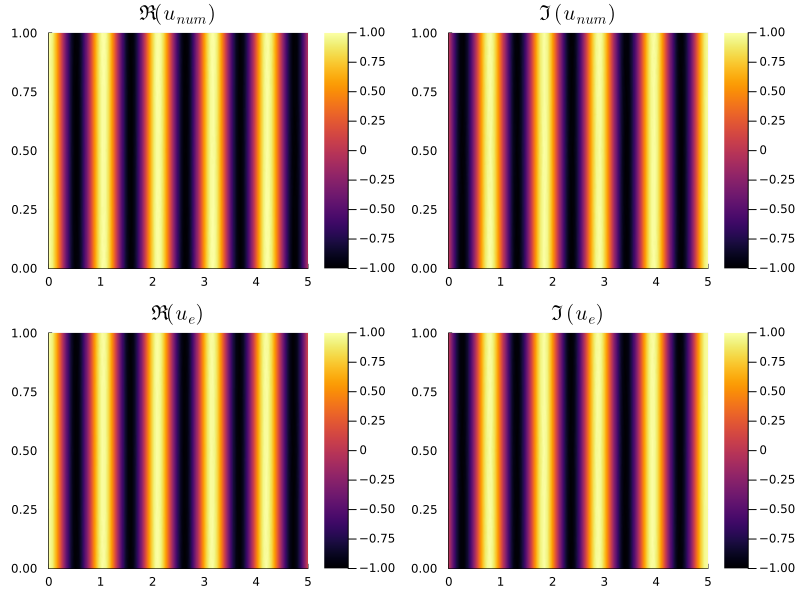

In [42]:
function plot_square_helmholtz()
    xmax = 5
    k = 6
    
    nref = 2
    pv = [0 0; xmax 0; xmax 1; 0 1; 0 0]
    p, t, e = pmesh(pv, 0.3, nref)
    
    u, intensity = solve_helmholtz(p, t, k)
    exact = u_exact.(p[:, 1], k)

    println(intensity)
    
    l = @layout [a b; c d]
    kwargs = (levels=21, clim=(-1, 1), aspect_ratio=:none)

    t1 = tplot(p, t; u=real.(u), title=L"\Re (u_{num})", kwargs...)
    t2 = tplot(p, t; u=imag.(u), title=L"\Im (u_{num})", kwargs...)
    t3 = tplot(p, t; u=real.(exact), title=L"\Re (u_e)", kwargs...)
    t4 = tplot(p, t; u=imag.(exact), title=L"\Im (u_e)", kwargs...)
    plot(t1, t2, t3, t4, layout=l, size=(800, 600))
    
end
plot_square_helmholtz()

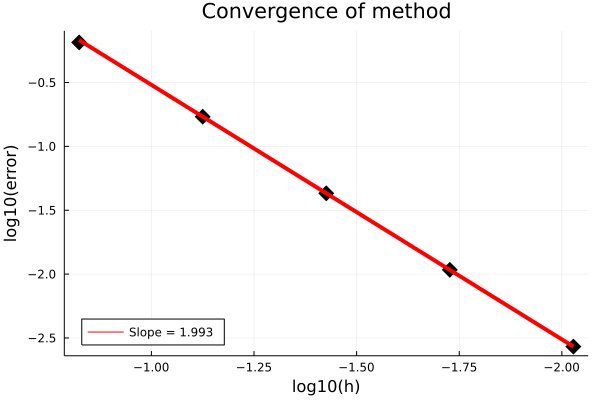

1.9928120183244622
1.474326156080944


In [43]:
function convergence_helmholtz()
    xmax = 5
    k = 6
    hmax = 0.3
    nrefmax = 5

    errs = zeros(nrefmax)
    hs = zeros(nrefmax)

    for nref = 1:nrefmax
        pv = [0 0; xmax 0; xmax 1; 0 1; 0 0]
        p, t, e = pmesh(pv, hmax, nref)

        u, _ = solve_helmholtz(p, t, k)
        exact = u_exact.(p[:, 1], k)
        
        errs[nref] = log10(maximum(abs.(exact - u)))
        hs[nref] = log10(hmax / (2^nref))
    end

    X = zeros(length(hs)-1, 2)
    X[:, 1] .= hs[2:end]
    X[:, 2] .= 1
    slope, inter = X \ errs[2:end]
    println(slope)
    println(inter)
    plot(hs, errs, c="black", markershapes=:diamond, st=:scatter, markersize=8, label=false)
    plot!(hs, inter .+ slope .* hs, c="red", lw=4, label="Slope = $(round(slope, digits=3))")
    P=plot!(title="Convergence of method", xaxis="log10(h)", yaxis="log10(error)", xflip=true, legend=:bottomleft)
    savefig("figs/convergence_helmholtz_.pdf")
    display(P)
end
convergence_helmholtz()

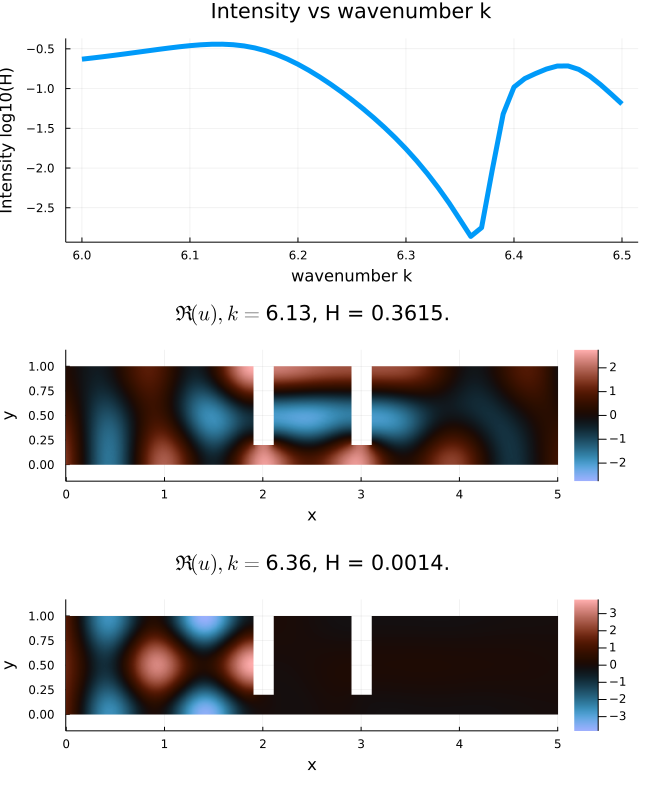

In [49]:
function frequency_response()
    # fully parametrerized rectangular domain with 2 slits
    xmax = 5   # length of domain
    ymax = 1   # height of domain
    sw = 0.2   # slit width
    sh = 0.2   # slit height
    s1 = 3     # centre of slit 2
    s2 = 2     # centre of slit 1
    pv = [0 0; xmax 0; xmax ymax; s1+sw/2 ymax; s1+sw/2 sh; s1-sw/2 sh; s1-sw/2 ymax; s2+sw/2 ymax; s2+sw/2 sh; s2-sw/2 sh; s2-sw/2 ymax; 0 ymax; 0 0]
    p, t, e = pmesh(pv, 0.2, 2)

    tplot(p, t; title="Mesh", xlabel="x", ylabel="y")
    savefig("figs/mesh.pdf")
    
    ks = []
    Is = []

    for k = 6:0.01:6.5 
        u, intensity = solve_helmholtz(p, t, k)
        
        push!(ks, k)
        push!(Is, intensity)
    end
    Hk = plot(ks, log10.(Is), xaxis="wavenumber k", yaxis="Intensity log10(H)", lw=5, label=:none, title="Intensity vs wavenumber k")

    l = @layout [a{0.4h}; b; c]

    _, mx = findmax(Is)
    _, mn = findmin(Is)
    umx, Hmx = solve_helmholtz(p, t, ks[mx])
    umn, Hmn = solve_helmholtz(p, t, ks[mn])

    cmx = maximum(abs.(real.(umx)))
    cmn = maximum(abs.(real.(umn)))

    Pmx = tplot(p, t; u=real.(umx), c=:berlin, clim=(-cmx, cmx), xaxis="x", yaxis="y", title=L"\Re(u),    k = "*"$(ks[mx]), H = $(round(Hmx, digits=4)).")
    Pmn = tplot(p, t; u=real.(umn), c=:berlin, clim=(-cmn, cmn), xaxis="x", yaxis="y", title=L"\Re(u),    k = "*"$(ks[mn]), H = $(round(Hmn, digits=4)).")
    P = plot(Hk, Pmx, Pmn, layout=l, size=(650, 800))
    savefig("figs/IvK_mx_mn.pdf")
    display(P)
end
frequency_response()

In [24]:
function solve_helmholtz(p, t, k)
    ein, eout, ewall = waveguide_edges(p, t)
    K, M, Bin, Bout, bin = femhelmholtz(p, t, ein, eout)
    
    A = K - k^2 * M + im * k * (Bin + Bout)
    b = 2im * k * bin
    
    u = A \ b
    return u, H(u, Bout)
end

solve_helmholtz (generic function with 1 method)

In [22]:
function waveguide_edges(p, t, xmax=5)
   edges, bnidx, _ = all_edges(t)
   ein, eout, ewall = [], [], []
   tol = 1e-8  # just for extra precaution, should be unnessisary
   for k = bnidx  # only loop over actual boundary nodes 
      # check verticality
      dy = abs(p[edges[k, 2], 2] - p[edges[k, 1], 2])  
      if dy > tol
         x = p[edges[k, 1], 1]
         if x < tol
            push!(ein, k)
         elseif x > xmax-tol
            push!(eout, k)
         end
      else
         push!(ewall, k)
      end
   end
   return edges[ein, :], edges[eout, :], edges[ewall, :]
end

waveguide_edges (generic function with 2 methods)

In [23]:
function femhelmholtz(p, t, ein, eout)
    n = size(p, 1)
    K, M, Bin, Bout = [], [], [], []
    bin = zeros(n)

    # integrate in the interiour
    for k = 1:size(t, 1)
        sK, sM = stamp(p, t[k, :])
        for i = 1:3, j=1:3
            push!(K, (t[k, i], t[k, j], sK[i, j]))
            push!(M, (t[k, i], t[k, j], sM[i, j]))
        end
    end

    # integrate along input boundary
    _sB() = [2 1; 1 2] / 6
    for k in 1:size(ein, 1)
        sB = _sB()
        d = edge_stamp!(sB, p, ein[k, :])
        for i=1:2, j=1:2
            push!(Bin, (ein[k, i], ein[k, j], sB[i, j]))
        end
        bin[ein[k, 1]] += d / 2
        bin[ein[k, 2]] += d / 2
    end
    
    # integrate along output boundary
    for k in 1:size(eout, 1)
        sB = _sB()
        edge_stamp!(sB, p, eout[k, :])
        for i=1:2, j=1:2
            push!(Bout, (eout[k, i], eout[k, j], sB[i, j]))
        end
    end
    
    sparsify(A, n=n) = sparse((x->x[1]).(A), (x->x[2]).(A), (x->x[3]).(A), n, n)
    return sparsify(K), sparsify(M), sparsify(Bin), sparsify(Bout), bin
end

femhelmholtz (generic function with 1 method)

In [21]:
function stamp(p, t)
    x1, y1 = p[t[1], :]
    x2, y2 = p[t[2], :]
    x3, y3 = p[t[3], :]

    area = (x1*y2 + x2*y3 + x3*y1 - y1*x2 - y2*x3 - y3*x1) / 2
    C = inv([1 x1 y1; 1 x2 y2; 1 x3 y3])

    sK = zeros(3, 3)
    for i = 1:3
        sK[i, i] = C[2, i]^2 + C[3, i]^2  # diagonal
        for j = 1:i-1  # off-diagonal
            sK[i, j] = C[2, i] * C[2, j] + C[3, i] * C[3, j]
            sK[j, i] = sK[i, j]  # symmetry
        end
    end
    sK *= area
    sM = (ones(3) .+ I(3)) / 24 * area * 2
    # divide by area of T0, which is 1/2

    return sK, sM
end

function edge_stamp!(B, p, t)
    d = norm(p[t[1], :] - p[t[2], :])
    B .*= d
    return d
end

edge_stamp! (generic function with 1 method)